In [ ]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!pip install -q roboflow supervision
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

#!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 95.3 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-abenwth5
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-abenwth5
  Resolved https://github.com/facebookresearch/segment-anything.git to com

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
workspace = '/content/gdrive/MyDrive/DeepGC/fMRI-SAM'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)


In [ ]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=128,
    pred_iou_thresh=0.75,
    stability_score_thresh=0.75,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=250,  # Requires open-cv to run post-processing
)

In [ ]:
np.random.seed(4)
def show_anns(anns, idx=[0]):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    # ax = plt.gca()
    # ax.set_autoscale_on(False)
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns[np.min(idx):np.max(idx)+1]:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        # color_mask = np.concatenate([[255, 0, 0], [0.35]])
        img[m] = color_mask
    # ax.imshow(img)
    return img

In [ ]:
import supervision as sv

def show_mask(masks, idx=[0]):
  masks = [
    mask['segmentation']
    for mask
    in sorted(masks, key=lambda x: x['area'], reverse=True)
  ]
  sv.plot_images_grid(
    images=masks[:4],
    grid_size=(2, int(len(masks)/ 8)+1),
    size=(16, 16)
  )
  mask = np.zeros(masks[0].shape)
  for id in idx:
    mask = np.logical_or(mask, masks[id])
  return mask


In [ ]:
image = cv2.imread(workspace + '/brain_top.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

sagittal_slice = image
# plot the image
sagittal_annotations = mask_generator.generate(sagittal_slice)
sagittal_slice_anns = show_anns(sagittal_annotations, [2,3])
sagittal_slice_mask = show_mask(sagittal_annotations, [2,3])
# Display the three orthogonal slices as 2D images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(sagittal_slice, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Sagittal Slice')
axes[1].imshow(sagittal_slice)
axes[1].imshow(sagittal_slice_anns)
axes[1].axis('off')
axes[1].set_title('Sagittal Slice Annotation')
axes[2].imshow(sagittal_slice_mask, cmap='gray')
axes[2].axis('off')
axes[2].set_title('Sagittal Slice Mask')
fig.savefig('sagittal_slice.jpg', format='jpg', bbox_inches='tight', pad_inches=0.05)

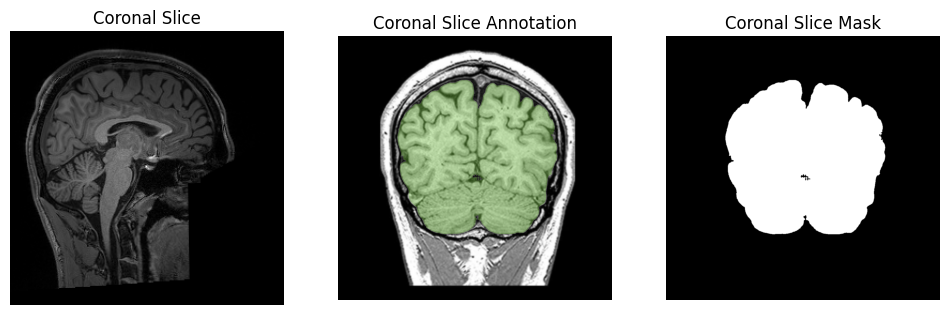

In [ ]:
image = cv2.imread(workspace + '/brain_side.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

coronal_slice = image
coronal_annotations = mask_generator.generate(coronal_slice)
coronal_slice_anns = show_anns(coronal_annotations, [2])
coronal_slice_mask = show_mask(coronal_annotations, [2])
# Display the three orthogonal slices as 2D images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
# plot the image
axes[0].imshow(sagittal_slice, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Coronal Slice')
axes[1].imshow(coronal_slice)
axes[1].imshow(coronal_slice_anns)
axes[1].axis('off')
axes[1].set_title('Coronal Slice Annotation')
axes[2].imshow(coronal_slice_mask, cmap='gray')
axes[2].axis('off')
axes[2].set_title('Coronal Slice Mask')
fig.savefig('coronal_slice.jpg', format='jpg', bbox_inches='tight', pad_inches=0.05)

3 3
(1000, 1000)


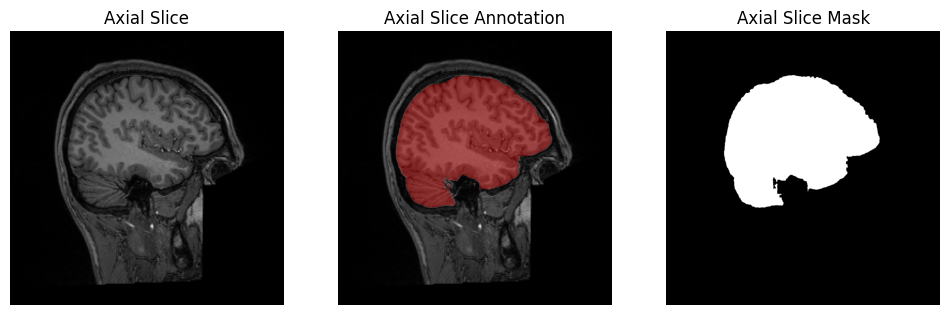

In [ ]:
image = cv2.imread(workspace + '/brain_left.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Display the three orthogonal slices as 2D images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axial_slice = image
# plot the image
axes[0].imshow(axial_slice, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Axial Slice')
axial_annotations = mask_generator.generate(axial_slice)
axial_slice_anns = show_anns(axial_annotations, [3])
axes[1].imshow(axial_slice)
axes[1].imshow(axial_slice_anns)
axes[1].axis('off')
axes[1].set_title('Axial Slice Annotation')
axial_slice_mask = show_mask(axial_annotations, [3])
axes[2].imshow(axial_slice_mask, cmap='gray')
axes[2].axis('off')
axes[2].set_title('Axial Slice Mask')
fig.savefig('axial_slice.jpg', format='jpg', bbox_inches='tight', pad_inches=0.05)

In [ ]:
!rm -rf workspace + '/fMRI_SAM_Masks/*'

In [ ]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=128,
    pred_iou_thresh=0.75,
    stability_score_thresh=0.75,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=250,  # Requires open-cv to run post-processing
)

In [ ]:
def preprocess(image):
  output = (image - np.min(image))/(np.max(image) - np.min(image))
  output = output * 255
  # output = cv2.equalizeHist(output)
  # # Convert grayscale to RGB if necessary
  if len(output.shape) == 2:
     output = np.stack((output,) * 3, axis=-1)
  return output.astype(np.uint8)

def bbox_check(bbox, h, w):
  if (bbox[0] <= 10) and (bbox[0] <= 10):
    return False
  if (bbox[2] >= h) and (bbox[3] >= w):
    return False
  return True

def filter_annotations(annotations):
  filtered_anns = []
  for annotation in annotations:
    bbox = annotation['bbox']
    # print(bbox)
    if bbox_check(bbox, 170, 250):
      filtered_anns.append(annotation)
  return filtered_anns

In [ ]:
import os
import pickle as pkl
dataset = workspace + '/fMRI_Images'
output_dir = workspace + '/fMRI_SAM_Masks'

def save_image(image_path, image):
  # Display the three orthogonal slices as 2D images
  fig, axes = plt.subplots(1, 1, figsize=(8, 8))
  axes.imshow(image, cmap='gray')
  axes.axis('off')
  fig.savefig(image_path, format='jpg', bbox_inches='tight', pad_inches=0.05)
  plt.close()

images_list = os.listdir(dataset)
# issue images
saggital_fix_list = ['sub-01_ses-004__sagittal.jpg', 'sub-01_ses-005__sagittal.jpg', 'sub-02_ses-001__sagittaljpg', 'sub-04_ses-001__sagittal.jpg',
                  'sub-04_ses-002__sagittal.jpg', 'sub-04_ses-003__sagittal.jpg', 'sub-04_ses-005__sagittal.jpg']
coronal_fix_list = ['sub-01_ses-003__coronal.jpg', '']
axial_fix_list = ['sub-01_ses-002__axial.jpg']
image_annotations_list = {}
count = 0
for i, image_file in enumerate(images_list):
  print(image_file)
  image_path = dataset + '/' + image_file
  image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = preprocess(image)
  print(image.shape)
  if 'sagittal' in image_path:
    image_annotations = mask_generator.generate(image)
    image_annotations = sorted(image_annotations, key=(lambda x: x['area']), reverse=True)
    image_annotations = filter_annotations(image_annotations)
    image_anns = show_anns(image_annotations, [1])
    out_image_path = output_dir + '/' + image_file[:-4] + '_anns.jpg'
    fig, axes = plt.subplots(1, 1, figsize=(8, 8))
    axes.imshow(image)
    axes.imshow(image_anns)
    axes.axis('off')
    fig.savefig(out_image_path, format='jpg', bbox_inches='tight', pad_inches=0.05)
    image_mask = show_mask(image_annotations, [1])
    image_path = output_dir + '/' + image_file[:-4] + '_mask.jpg'
    save_image(image_path, image_mask)
    count += 1
  # if 'coronal' in image_path:
  #   image_annotations = mask_generator.generate(image)
  #   image_annotations = sorted(image_annotations, key=(lambda x: x['area']), reverse=True)
  #   # image_annotations = filter_annotations(image_annotations)
  #   image_anns = show_anns(image_annotations, [1])
  #   out_image_path = output_dir + '/' + image_file[:-4] + '_anns.jpg'
  #   fig, axes = plt.subplots(1, 1, figsize=(8, 8))
  #   axes.imshow(image)
  #   axes.imshow(image_anns)
  #   axes.axis('off')
  #   fig.savefig(out_image_path, format='jpg', bbox_inches='tight', pad_inches=0.05)
  #   image_mask = show_mask(image_annotations, [1])
  #   image_path = output_dir + '/' + image_file[:-4] + '_mask.jpg'
  #   save_image(image_path, image_mask)
  #   count += 1
  # elif 'axial' in image_path:
  #   image_annotations = mask_generator.generate(image)
  #   image_annotations = sorted(image_annotations, key=(lambda x: x['area']), reverse=True)
  #   image_annotations = filter_annotations(image_annotations)
  #   image_annotations = filter_annotations(image_annotations)
  #   image_annotations_list[image_file] = image_annotations
  #   image_anns = show_anns(image_annotations, [0])
  #   print(image_annotations[0].keys())
  #   out_image_path = output_dir + '/' + image_file[:-4] + '_anns.jpg'
  #   fig, axes = plt.subplots(1, 1, figsize=(8, 8))
  #   axes.imshow(image)
  #   axes.imshow(image_anns)
  #   axes.axis('off')
  #   fig.savefig(out_image_path, format='jpg', bbox_inches='tight', pad_inches=0.05)
  #   image_mask = show_mask(image_annotations, [0])
  #   image_path = output_dir + '/' + image_file[:-4] + '_mask.jpg'
  #   save_image(image_path, image_mask)
  else:
    continue
  image_path = output_dir + '/' + image_file
  save_image(image_path, image)
  # image_path = output_dir + '/' + image_file[-4] + '_anns.jpg'
  # save_image(image_path, image_anns)
  # image_path = output_dir + '/' + image_file[:-4] + '_mask.jpg'
  # save_image(image_path, image_mask)
  print(i)
  if count == 1:
    break

with open(workspace + '/image_annotations_coronal.pkl', 'wb') as file:
    pkl.dump(image_annotations_list, file)

In [ ]:
def preprocess(image):
  output = (image - np.min(image))/(np.max(image) - np.min(image))
  output = output * 255
  # Convert grayscale to RGB if necessary
  if len(output.shape) == 2:
    output = np.stack((output,) * 3, axis=-1)
  return output.astype(np.uint8)

In [ ]:
def sam_seg_sagittal(image):
  # Display the three orthogonal slices as 2D images
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  sagittal_slice = image
  # plot the image
  axes[0].imshow(sagittal_slice, cmap='gray')
  axes[0].axis('off')
  axes[0].set_title('Sagittal Slice')
  sagittal_annotations = mask_generator.generate(sagittal_slice)
  sagittal_slice_anns = show_anns(sagittal_annotations, [2,3])
  axes[1].imshow(sagittal_slice)
  axes[1].imshow(sagittal_slice_anns)
  axes[1].axis('off')
  axes[1].set_title('Sagittal Slice Annotation')
  sagittal_slice_mask = show_mask(sagittal_annotations, [2,3])
  axes[2].imshow(sagittal_slice_mask, cmap='gray')
  axes[2].axis('off')
  axes[2].set_title('Sagittal Slice Mask')
  # fig.savefig('sagittal_slice.jpg', format='jpg', bbox_inches='tight', pad_inches=0.05)
  # Adjust the layout and display the figure
  plt.tight_layout()
  plt.show()

In [ ]:
import os
import nibabel as nib
# Specify the path to the file
dataset_path = workspace + "/fMRI_Dataset/"
output_path = workspace + "/fMRI_Images/"
dataset_files = os.listdir(dataset_path)

for input_file in sorted(dataset_files):
  print(input_file)
  # Load the NIfTI file
  nifti_img = nib.load(dataset_path + input_file)
  # Access the data array
  data = nifti_img.get_fdata()
  # Sagittal slice (middle slice along x-axis)
  sagittal_slice = preprocess(np.rot90(data[data.shape[0]//2, :, :]))
  # Coronal slice (middle slice along y-axis)
  coronal_slice = preprocess(np.rot90(data[:, data.shape[1]//2, :]))
  # Axial slice (middle slice along z-axis)
  axial_slice = preprocess(np.rot90(data[:, :, data.shape[2]//2]))
  # plot the images
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  axes[0].imshow(sagittal_slice, cmap='gray')
  axes[0].axis('off')
  axes[0].set_title('sagittal_slice')
  axes[1].imshow(coronal_slice)
  axes[1].axis('off')
  axes[1].set_title('coronal_slice')
  axes[2].imshow(axial_slice, cmap='gray')
  axes[2].axis('off')
  axes[2].set_title('axial_slice')
  fig.savefig(output_path + '/{}_sagittal.jpg'.format(input_file[:-10]), format='jpg', bbox_inches='tight', pad_inches=0.05)
  fig.savefig(output_path + '/{}_coronal.jpg'.format(input_file[:-10]), format='jpg', bbox_inches='tight', pad_inches=0.05)
  fig.savefig(output_path + '/{}_axial.jpg'.format(input_file[:-10]), format='jpg', bbox_inches='tight', pad_inches=0.05)


In [ ]:
import nibabel as nib
# Specify the path to the file
file_path = workspace + "/sub-01_ses-001_T1w.nii.gz"
# Load the NIfTI file
nifti_img = nib.load(file_path)
# Access the data array
data = nifti_img.get_fdata()

for i in range(30, 150, 10): # data.shape[0]):
  print('slice idx:', i)
  image_slice = preprocess(data[:, :, i])
  sam_seg_sagittal(image_slice)

In [ ]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=64,
    pred_iou_thresh=0.80,
    stability_score_thresh=0.80,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=250,  # Requires open-cv to run post-processing
)

In [ ]:
print(len(masks))
print(masks[0].keys())

9
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [ ]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=16,
    pred_iou_thresh=0.80,
    stability_score_thresh=0.90,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=500,  # Requires open-cv to run post-processing
)

In [ ]:
masks2 = mask_generator_2.generate(image)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()
# Save the plot as an image file
plt.savefig('brain_top_seg.jpg')  # Specify the desired image file name and extension

In [ ]:
import supervision as sv
masks = [
    mask['segmentation']
    for mask
    in sorted(masks2, key=lambda x: x['area'], reverse=True)
]
print(len(masks))
sv.plot_images_grid(
    images=masks[:4],
    grid_size=(2, int(len(masks)/ 8)+1),
    size=(16, 16)
)

In [ ]:
image = cv2.imread(workspace + '/brain_side.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(np.min(image), np.max(image))
masks2 = mask_generator_2.generate(image)

plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()
# Save the plot as an image file
plt.savefig('brain_side_seg.jpg')  # Specify the desired image file name and extension

In [ ]:
import supervision as sv
masks = [
    mask['segmentation']
    for mask
    in sorted(masks2, key=lambda x: x['area'], reverse=True)
]
print(len(masks))
sv.plot_images_grid(
    images=masks[:4],
    grid_size=(2, int(len(masks)/ 8)+1),
    size=(16, 16)
)

In [ ]:
image = cv2.imread(workspace + '/brain_left.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)
masks2 = mask_generator_2.generate(image)

plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()
# Save the plot as an image file
plt.savefig('brain_left_seg.jpg')  # Specify the desired image file name and extension

In [ ]:
import supervision as sv
masks = [
    mask['segmentation']
    for mask
    in sorted(masks2, key=lambda x: x['area'], reverse=True)
]
print(len(masks))
sv.plot_images_grid(
    images=masks[:4],
    grid_size=(2, int(len(masks)/ 8)+1),
    size=(16, 16)
)

In [ ]:
import nibabel as nib

# Specify the path to the file
file_path = workspace + "/sub-01_ses-001_T1w.nii.gz"

# Load the NIfTI file
nifti_img = nib.load(file_path)

# Access the data array
data = nifti_img.get_fdata()

# Display the shape of the data array
print("Data shape:", data.shape)

# sv.plot_images_grid(
#     images=data,
#     grid_size=(8, int(len(data)/ 8)+1),
#     size=(16, 16)
# )

for i in range(data.shape[0]):
  image_slice = data[i, :, :]
  print(i, image_slice.shape)
  plt.figure(figsize=(10,10))
  plt.imshow(image_slice, cmap='gray')
  plt.axis('off')
  plt.show()

In [ ]:
# Sagittal slice (middle slice along x-axis)
!mkdir os.path.join(workspace + '/sagittal_slices')
# Coronal slice (middle slice along y-axis)
!mkdir os.path.join(workspace + '/coronal_slices')
# Axial slice (middle slice along z-axis)
!mkdir os.path.join(workspace + '/axial_slices')

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `mkdir os.path.join(workspace + '/sagittal_slices')'
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `mkdir os.path.join(workspace + '/coronal_slices')'
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `mkdir os.path.join(workspace + '/axial_slices')'


In [ ]:
for i in range(data.shape[0]):
  image_slice = data[i, :, :]
  print(i, image_slice.shape)
  plt.figure(figsize=(10,10))
  fig, ax = plt.subplots(figsize=(10, 10))
  norm_image_slice = (image_slice - np.min(image_slice)) / (np.max(image_slice) - np.min(image_slice) + 1e-8)
  ax.imshow(norm_image_slice, cmap='gray')
  ax.axis('off')
  # Adjust plot layout to remove margins
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
  # Save the plot as a JPG image
  plt.savefig(workspace + "/sagittal_slices/slice_{}.jpg".format(i), format='jpg', bbox_inches='tight', pad_inches=0)
  # Close the plot (optional)
  plt.close()

In [ ]:
for i in range(data.shape[1]):
  image_slice = data[:, i, :]
  print(i, image_slice.shape)
  fig, ax = plt.subplots(figsize=(10, 10))
  norm_image_slice = (image_slice - np.min(image_slice)) / (np.max(image_slice) - np.min(image_slice) + 1e-8)
  ax.imshow(norm_image_slice, cmap='gray')
  ax.axis('off')
  # Adjust plot layout to remove margins
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
  # Save the plot as a JPG image
  plt.savefig(workspace + "/coronal_slices/slice_{}.jpg".format(i), format='jpg')
  # Close the plot (optional)
  plt.close()

In [ ]:
for i in range(data.shape[2]):
  image_slice = data[:, :, i]
  print(i, image_slice.shape)
  fig, ax = plt.subplots(figsize=(10, 10))
  norm_image_slice = (image_slice - np.min(image_slice)) / (np.max(image_slice) - np.min(image_slice) + 1e-8)
  ax.imshow(norm_image_slice, cmap='gray')
  ax.axis('off')
  # Adjust plot layout to remove margins
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
  # Save the plot as a JPG image
  plt.savefig(workspace + "/axial_slices/slice_{}.jpg".format(i), format='jpg')
  # Close the plot (optional)
  plt.close()

In [ ]:
def norm_image(image):
  norm_image = (image - np.min(image))/ (np.max(image) - np.min(image) + 1e-8)
  norm_image = norm_image * 255
  return norm_image.astype(np.uint8)

In [ ]:
# function to segment and save the mask
def seg_sam_mask(image):
  masks = mask_generator_2.generate(image)
  # sort masks by size
  sorted_masks = [
    mask['segmentation']
    for mask
    in sorted(masks, key=lambda x: x['area'], reverse=True)
  ]
  # print first four sorted masks
  sv.plot_images_grid(
    images=sorted_masks,
    grid_size=(4, int(len(sorted_masks)/ 4)+1),
    size=(4, int(len(sorted_masks)/ 4))
  )
  image_mask = None
  if len(sorted_masks) >= 4:
    print('select third mask')
    image_mask = sorted_masks[2] # np.logical_or(sorted_masks[2], sorted_masks[3])
  return image_mask

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Specify the path to the file
file_path = workspace + "/sub-01_ses-001_T1w.nii.gz"

# Load the NIfTI file
nifti_img = nib.load(file_path)

# Access the data array
data = nifti_img.get_fdata()

# Sagittal slice (middle slice along x-axis)
sagittal_slice = np.rot90(data[data.shape[0]//2, :, :])

# normalize the image
sagittal_slice = norm_image(sagittal_slice)

# Convert grayscale to RGB if necessary
if len(sagittal_slice.shape) == 2:
    sagittal_slice = np.stack((sagittal_slice,) * 3, axis=-1)
sagittal_mask = seg_sam_mask(sagittal_slice)

# Coronal slice (middle slice along y-axis)
coronal_slice = np.rot90(data[:, data.shape[1]//2, :])
coronal_slice = norm_image(coronal_slice)
# Convert grayscale to RGB if necessary
if len(coronal_slice.shape) == 2:
    coronal_slice = np.stack((coronal_slice,) * 3, axis=-1)
coronal_mask = seg_sam_mask(coronal_slice)

# Axial slice (middle slice along z-axis)
axial_slice = np.rot90(data[:, :, data.shape[2]//2])
axial_slice = norm_image(axial_slice)
# Convert grayscale to RGB if necessary
if len(axial_slice.shape) == 2:
    axial_slice = np.stack((axial_slice,) * 3, axis=-1)
axial_mask = seg_sam_mask(axial_slice)

# Display the three orthogonal slices as 2D images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
# plot the image
axes[0].imshow(sagittal_slice, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Sagittal Slice')

axes[1].imshow(coronal_slice, cmap='gray')
axes[1].axis('off')
axes[1].set_title('Coronal Slice')

axes[2].imshow(axial_slice, cmap='gray')
axes[2].axis('off')
axes[2].set_title('Axial Slice')

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()

# Display the three orthogonal slices as 2D images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Sagittal mask (middle slice along x-axis)
axes[0].imshow(sagittal_mask, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Sagittal Mask')

# Coronal slice (middle slice along y-axis)
axes[1].imshow(coronal_mask, cmap='gray')
axes[1].axis('off')
axes[1].set_title('Coronal Mask')

# Axial slice (middle slice along z-axis)
axes[2].imshow(axial_mask, cmap='gray')
axes[2].axis('off')
axes[2].set_title('Axial Mask')
# Adjust the layout and display the figure
plt.tight_layout()
plt.show()

In [ ]:
# function to segment and save the mask
def seg_sam_mask(image):
  masks = mask_generator_2.generate(image)
  # sort masks by size
  # sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=True)
  sorted_masks = [
    mask['segmentation']
    for mask
    in sorted(masks, key=lambda x: x['area'], reverse=True)
  ]
  image_mask = None
  if len(sorted_masks) >= 4:
    image_mask = sorted_masks[0]
    # np.logical_and(sorted_masks[2], sorted_masks[3])
  return image_mask

In [ ]:
# plot and save images
def save_mask(mask, image_dir, image_name, save=True):
  if mask is None:
    return
  plt.figure(figsize=(10,10))
  plt.imshow(mask, cmap='gray')
  plt.axis('off')
  # Save the plot as a JPG image
  plt.savefig(images_dir + '/' + image_slice[:-4] + '_mask.jpg', format='jpg')
  # Close the plot (optional)
  plt.close()

# show masks
def show_masks(mask):
  if mask is None:
    return None
  ax = plt.gca()
  ax.set_autoscale_on(False)
  img = np.ones((mask.shape[0], mask.shape[1], 4))
  img[:,:,3] = 0
  color_mask = np.concatenate([np.random.random(3), [0.35]])
  img[mask] = color_mask
  ax.imshow(img)
  return img

# plot and save images
def save_anns(anns, image_dir, image_name, save=True):
  if anns is None:
    return
  plt.figure(figsize=(10,10))
  plt.imshow(anns)
  plt.axis('off')
  # Save the plot as a JPG image
  plt.savefig(images_dir + '/' + image_slice[:-4] + '_mask_anns.jpg', format='jpg')
  # Close the plot (optional)
  plt.close()

def plot_image(image):
  plt.figure(figsize=(10,10))
  plt.imshow(image, cmap='gray')
  plt.axis('off')
  plt.show()

In [ ]:
import os
# image directory
images_dir = workspace + '/sagittal_slices'
image_slices = os.listdir(workspace + '/sagittal_slices/')
image_slices = ['slice_100.jpg']
for image_slice in sorted(image_slices):
  if 'mask' in image_slice:
    continue
  print(image_slice)
  image = cv2.imread(workspace + '/sagittal_slices/' + image_slice)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plot_image(image)
  image_mask = seg_sam_mask(image)
  plot_image(image_mask)
  save_mask(image_mask, images_dir, image_slice)
  image_mask_ann = show_masks(image_mask)
  save_anns(image_mask_ann, images_dir, image_slice)